# 2.0 Augmentation & Feature Extraction

### Required Modules and Setup

In [24]:
import os
from shutil import copyfile
import pandas as pd
import cv2
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from helpers.file_system_utils import *
from helpers.image_utils import *

## 2.1 Pose Mirroring
- In the first version of the dataset, the images were mirrored to whichever side is missing.
- In the second version of the dataset, the poses were mirrored using transformation matrix.

### 2.1.1 Image Mirroring

In [1]:
def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))

def flip_image_horizontally(image_path, save_path):
    img = Image.open(image_path)
    flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
    flipped_img.save(save_path)

def pose_image_mirror(root_dir):
    error = 0
    copy_count = 0
    flipped_horizontal_count = 0
    flipped_vertical_count = 0

    lft_images_dir = root_dir + "lft/"
    rgt_images_dir = root_dir + "rgt/"

    for dir_path, suffix in [(lft_images_dir, '-lft.png'), (rgt_images_dir, '-rgt.png')]:
        for filename in os.listdir(dir_path):
            if is_image_file(filename):
                base_filename = os.path.splitext(filename)[0]
                source_path = os.path.join(dir_path, filename)
                save_path = os.path.join(root_dir, base_filename + suffix)
                copyfile(source_path, save_path)
                copy_count += 1
    print(f"Successfully copied {copy_count} images")

    for filename in os.listdir(root_dir):
        if is_image_file(filename) and filename.lower().endswith('-lft.png'):
            base_filename = filename.replace('-lft.png', '')
            flipped_path = os.path.join(root_dir, base_filename + '-rgt.png')
            source_path = os.path.join(root_dir, filename)
            flip_image_horizontally(source_path, flipped_path)
            flipped_horizontal_count += 1 
        elif is_image_file(filename) and filename.lower().endswith('-rgt.png'):
            base_filename = filename.replace('-rgt.png', '')
            flipped_path = os.path.join(root_dir, base_filename + '-lft.png')
            source_path = os.path.join(root_dir, filename)
            flip_image_horizontally(source_path, flipped_path)
            flipped_horizontal_count += 1 
        else:
            error += 1
            
    print(f"Successfully flipped horizontally {flipped_horizontal_count} images")

### 2.1.2 Pose Mirroring using Element-wise Operation

Since it was discovered that image mirroring results to separating data points of a class (trial 3), a much simpler method was used to flip the data points horizontally.

In [105]:
data = pd.read_csv('data/training-set-2/pose_data_raw.csv')
data = data.loc[:, ~data.columns.str.contains('_v')] #Removed Visibility Variables

# Invert y-values, so vectors are not upside down
for column in data.columns:
    if column.endswith('_y'):
        data[column] = 1 - data[column]

flipped_data = data.copy()

for column in flipped_data.columns:
    if column.endswith('_x'):
        flipped_data[column] = 1 - flipped_data[column]    

flipped_data

,image_filename,pose_name,landmark_00_x,landmark_00_y,landmark_00_z,landmark_01_x,landmark_01_y,landmark_01_z,landmark_02_x,landmark_02_y,...,landmark_29_z,landmark_30_x,landmark_30_y,landmark_30_z,landmark_31_x,landmark_31_y,landmark_31_z,landmark_32_x,landmark_32_y,landmark_32_z
0,ampit-thigh-hold-flying-ballerina.png,ampit-thigh-hold-flying-ballerina,0.718778,0.728519,-0.565210,0.715687,0.742852,-0.549514,0.711627,0.748928,...,0.671527,0.707712,0.104743,-0.052990,0.080956,0.389973,0.563735,0.781029,0.068422,-0.176583
1,ankle-hold-bow-and-arrow-release.png,ankle-hold-bow-and-arrow-release,0.137247,0.255983,0.012239,0.155976,0.242157,-0.021953,0.160892,0.243400,...,-0.262630,0.515768,0.879231,0.218394,0.804720,0.840648,-0.484034,0.426782,0.937869,0.020832
2,ankle-shoulder-hold-bow-and-arrow.png,ankle-shoulder-hold-bow-and-arrow,0.725607,0.354811,-0.476614,0.739740,0.363595,-0.483560,0.739136,0.367121,...,-0.148442,0.127747,0.325421,0.495671,0.654865,0.921453,-0.269996,0.111430,0.260021,0.418949
3,armpit-elbow-hold-inverted-split.png,armpit-elbow-hold-inverted-split,0.583231,0.397263,-0.523792,0.603764,0.386257,-0.502519,0.611800,0.389441,...,0.092699,0.484147,0.219377,-0.421314,0.539779,0.892810,-0.027153,0.549120,0.163851,-0.486730
4,armpit-elbow-hold-libellula-variation-.png,armpit-elbow-hold-libellula-variation-,0.499381,0.828898,-0.157715,0.508990,0.849083,-0.114404,0.510496,0.849823,...,0.002949,0.818318,0.112376,-0.066283,0.047510,0.163482,-0.202151,0.894127,0.075941,-0.260771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,two-hand-glute-hold-front-split.png,two-hand-glute-hold-front-split,0.141300,0.515406,-0.347617,0.140487,0.497115,-0.380478,0.143534,0.495110,...,-0.009858,0.527373,0.106307,0.224123,0.525848,0.858161,-0.107097,0.578169,0.037148,0.098553
285,two-hand-shoulder-hold-fang.png,two-hand-shoulder-hold-fang,0.454592,0.740922,-0.407526,0.470457,0.728610,-0.377108,0.470014,0.724919,...,0.468260,0.698755,0.325765,-0.279319,0.821504,0.312144,0.396094,0.834425,0.312704,-0.299426
286,two-hand-side-hold.png,two-hand-side-hold,0.131858,0.479147,-1.213130,0.111039,0.462576,-1.214312,0.112638,0.454251,...,0.176055,0.519524,0.457745,0.296394,0.871522,0.193358,-0.132542,0.594266,0.431340,0.096398
287,two-handed-arch-ankle-hold-fish-hook.png,two-handed-arch-ankle-hold-fish-hook,0.486716,0.231161,0.034273,0.506402,0.228556,0.005899,0.508032,0.229939,...,-0.003472,0.659954,0.882301,0.232962,0.098533,0.693496,-0.028855,0.593697,0.950236,0.155207


In [106]:
def swap_landmark_values(df, start, end, suffixes):
    for i in range(start, end, 2):  # Iterate in steps of 2 to get each pair
        for suffix in suffixes:
            odd_col_name = f'landmark_{i:02}{suffix}'
            even_col_name = f'landmark_{i+1:02}{suffix}'            
            if odd_col_name in df.columns and even_col_name in df.columns:
                df[odd_col_name], df[even_col_name] = df[even_col_name].copy(), df[odd_col_name].copy()
                print("swapped:",odd_col_name,even_col_name)

swap_landmark_values(flipped_data, 1, 33, ['_x', '_y', '_z'])

flipped_data.tail()

swapped: landmark_01_x landmark_02_x
swapped: landmark_01_y landmark_02_y
swapped: landmark_01_z landmark_02_z
swapped: landmark_03_x landmark_04_x
swapped: landmark_03_y landmark_04_y
swapped: landmark_03_z landmark_04_z
swapped: landmark_05_x landmark_06_x
swapped: landmark_05_y landmark_06_y
swapped: landmark_05_z landmark_06_z
swapped: landmark_07_x landmark_08_x
swapped: landmark_07_y landmark_08_y
swapped: landmark_07_z landmark_08_z
swapped: landmark_09_x landmark_10_x
swapped: landmark_09_y landmark_10_y
swapped: landmark_09_z landmark_10_z
swapped: landmark_11_x landmark_12_x
swapped: landmark_11_y landmark_12_y
swapped: landmark_11_z landmark_12_z
swapped: landmark_13_x landmark_14_x
swapped: landmark_13_y landmark_14_y
swapped: landmark_13_z landmark_14_z
swapped: landmark_15_x landmark_16_x
swapped: landmark_15_y landmark_16_y
swapped: landmark_15_z landmark_16_z
swapped: landmark_17_x landmark_18_x
swapped: landmark_17_y landmark_18_y
swapped: landmark_17_z landmark_18_z
s

,image_filename,pose_name,landmark_00_x,landmark_00_y,landmark_00_z,landmark_01_x,landmark_01_y,landmark_01_z,landmark_02_x,landmark_02_y,...,landmark_29_z,landmark_30_x,landmark_30_y,landmark_30_z,landmark_31_x,landmark_31_y,landmark_31_z,landmark_32_x,landmark_32_y,landmark_32_z
284,two-hand-glute-hold-front-split.png,two-hand-glute-hold-front-split,0.141300,0.515406,-0.347617,0.143534,0.495110,-0.380924,0.140487,0.497115,...,0.224123,0.568135,0.794633,-0.009858,0.578169,0.037148,0.098553,0.525848,0.858161,-0.107097
285,two-hand-shoulder-hold-fang.png,two-hand-shoulder-hold-fang,0.454592,0.740922,-0.407526,0.470014,0.724919,-0.377690,0.470457,0.728610,...,-0.279319,0.690712,0.327794,0.468260,0.834425,0.312704,-0.299426,0.821504,0.312144,0.396094
286,two-hand-side-hold.png,two-hand-side-hold,0.131858,0.479147,-1.213130,0.112638,0.454251,-1.214917,0.111039,0.462576,...,0.296394,0.801750,0.259865,0.176055,0.594266,0.431340,0.096398,0.871522,0.193358,-0.132542
287,two-handed-arch-ankle-hold-fish-hook.png,two-handed-arch-ankle-hold-fish-hook,0.486716,0.231161,0.034273,0.508032,0.229939,0.005576,0.506402,0.228556,...,0.232962,0.186282,0.630200,-0.003472,0.593697,0.950236,0.155207,0.098533,0.693496,-0.028855
288,wrist-sit-straddle.png,wrist-sit-straddle,0.322225,0.574214,0.383360,0.319911,0.582020,0.435656,0.319923,0.582766,...,-0.505073,0.289830,0.121816,-0.327056,0.379728,0.902461,-0.575896,0.192261,0.109892,-0.443614


In [107]:
combined_data = pd.concat([data, flipped_data], axis=0).reset_index(drop=True)
combined_data.rename(columns={'pose_name': 'label'}, inplace=True)

labels, uniques = pd.factorize(combined_data['label'])
combined_data.insert(2, 'label_encoded', labels)  # Inserting at index 2 makes it the 3rd column

# Step 3: Sort the DataFrame alphabetically by the 'label' column
combined_data.sort_values(by='label', inplace=True)
combined_data.reset_index(drop=True, inplace=True)  # Optionally reset the index after sorting
combined_data.head()  # Display the first few rows to verify the changes

,image_filename,label,label_encoded,landmark_00_x,landmark_00_y,landmark_00_z,landmark_01_x,landmark_01_y,landmark_01_z,landmark_02_x,...,landmark_29_z,landmark_30_x,landmark_30_y,landmark_30_z,landmark_31_x,landmark_31_y,landmark_31_z,landmark_32_x,landmark_32_y,landmark_32_z
0,ampit-thigh-hold-flying-ballerina.png,ampit-thigh-hold-flying-ballerina,0,0.281222,0.728519,-0.565210,0.284313,0.742852,-0.549514,0.288373,...,0.671527,0.292288,0.104743,-0.052990,0.919044,0.389973,0.563735,0.218971,0.068422,-0.176583
1,ampit-thigh-hold-flying-ballerina.png,ampit-thigh-hold-flying-ballerina,0,0.718778,0.728519,-0.565210,0.711627,0.748928,-0.550187,0.715687,...,-0.052990,0.143786,0.413047,0.671527,0.781029,0.068422,-0.176583,0.080956,0.389973,0.563735
2,ankle-hold-bow-and-arrow-release.png,ankle-hold-bow-and-arrow-release,1,0.137247,0.255983,0.012239,0.160892,0.243400,-0.022621,0.155976,...,0.218394,0.798371,0.757489,-0.262630,0.426782,0.937869,0.020832,0.804720,0.840648,-0.484034
3,ankle-hold-bow-and-arrow-release.png,ankle-hold-bow-and-arrow-release,1,0.862753,0.255983,0.012239,0.844024,0.242157,-0.021953,0.839108,...,-0.262630,0.484232,0.879231,0.218394,0.195280,0.840648,-0.484034,0.573218,0.937869,0.020832
4,ankle-shoulder-hold-bow-and-arrow.png,ankle-shoulder-hold-bow-and-arrow,2,0.274393,0.354811,-0.476614,0.260260,0.363595,-0.483560,0.260864,...,-0.148442,0.872253,0.325421,0.495671,0.345135,0.921453,-0.269996,0.888570,0.260021,0.418949


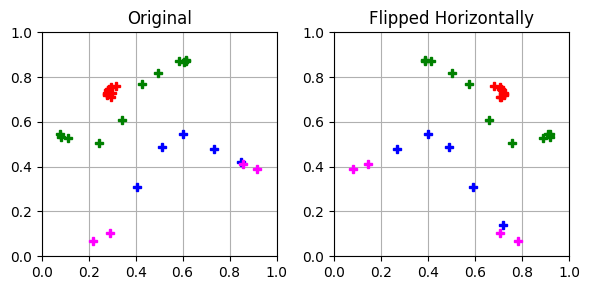

In [109]:
x = combined_data.loc[0, combined_data.columns.str.contains('_x')].tolist()
y = combined_data.loc[0, combined_data.columns.str.contains('_y')].tolist()

flipped_x = combined_data.loc[1, combined_data.columns.str.contains('_x')].tolist()
flipped_y = combined_data.loc[1, combined_data.columns.str.contains('_y')].tolist()

fig, axes = plt.subplots(1,2, figsize=(6, 3))
axes[0].plot(x[0:10], y[0:10], color=mcolors.CSS4_COLORS['red'], label="head", marker='P', linestyle='None')
axes[0].plot(x[11:22], y[11:22], color=mcolors.CSS4_COLORS['green'], label="mid body", marker='P', linestyle='None')
axes[0].plot(x[23:28], y[23:28], color=mcolors.CSS4_COLORS['blue'], label="lower body", marker='P', linestyle='None')
axes[0].plot(x[29:33], y[29:33], color=mcolors.CSS4_COLORS['magenta'], label="feet", marker='P', linestyle='None')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)
axes[0].set_title("Original")
axes[0].grid()

axes[1].plot(flipped_x[0:10], flipped_y[0:10], color=mcolors.CSS4_COLORS['red'], label="head", marker='P', linestyle='None')
axes[1].plot(flipped_x[11:22], flipped_y[11:22], color=mcolors.CSS4_COLORS['green'], label="mid body", marker='P', linestyle='None')
axes[1].plot(flipped_x[23:28], flipped_y[23:28], color=mcolors.CSS4_COLORS['blue'], label="lower body", marker='P', linestyle='None')
axes[1].plot(flipped_x[29:33], flipped_y[29:33], color=mcolors.CSS4_COLORS['magenta'], label="feet", marker='P', linestyle='None')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].grid()
axes[1].set_title("Flipped Horizontally")
fig.tight_layout()
plt.show()

In [110]:
combined_data.to_csv('data/training-set-2/pose_data_aug.csv',index=False)

## 2.2 Pose Feature Extraction and Compilation using Mediapipe

In [2]:
def initialize_landmarker(model_path):
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.PoseLandmarkerOptions(base_options=base_options, output_segmentation_masks=True)
    return vision.PoseLandmarker.create_from_options(options)

def populate_pose_data_with_landmarks(pose_info, landmarks):
    for idx, landmark in enumerate(landmarks):
        idx_str = str(idx).zfill(2)
        pose_info[f'landmark_{idx_str}_x'] = landmark.x
        pose_info[f'landmark_{idx_str}_y'] = landmark.y
        pose_info[f'landmark_{idx_str}_z'] = landmark.z
        pose_info[f'landmark_{idx_str}_v'] = landmark.visibility
        
def generate_pose_landmark_dictionary(source_dir, model_path, is_video=False):
    annotated_dir = create_annotated_directory(source_dir)
    filenames = get_image_filenames(source_dir)
    landmarker = initialize_landmarker(model_path)

    if is_video:
        pose_data, errors = batch_process_video_images(annotated_dir, filenames, landmarker)
    else:
        pose_data, errors = batch_process_static_images(annotated_dir, filenames, landmarker)
    
    pose_data_df = pd.DataFrame(pose_data)
    pose_data_df.to_csv(f'{source_dir}/pose_data_raw.csv', index=False)
    
    errors = write_error_log(source_dir, errors)
    
    return print(annotated_dir)

def batch_process_video_images(annotated_dir, filenames, landmarker):
    pose_data = []
    errors = []

    for image_file_path in sorted(filenames):
        
        image_bgr = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)

        image_filename, second, frame_no = parse_video_filename(image_file_path)
        detection_result = landmarker.detect(mp_image)

        if detection_result.pose_landmarks:
            annotate_and_save_image(annotated_dir, image_filename, detection_result, image_rgb, scale=0.4)
            
            for landmarks in detection_result.pose_landmarks:
                pose_info = {
                    'image_filename': image_filename,
                    'secs': second,
                    'frame_no': frame_no
                }
                populate_pose_data_with_landmarks(pose_info, landmarks)
            pose_data.append(pose_info)
        else:
            errors.append(image_file_path)
    
    return pose_data, errors

def batch_process_static_images(annotated_dir, filenames, landmarker):
    
    pose_data = []
    errors = []

    for image_file_path in sorted(filenames):
        
        image_bgr = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)

        image_filename = os.path.basename(image_file_path)        
        pose_name = image_filename.split('.')[0]
        
        detection_result = landmarker.detect(mp_image)
        
        if detection_result.pose_landmarks:
            annotate_and_save_image(annotated_dir, image_filename, detection_result, image_rgb, scale=1)
            
            for landmarks in detection_result.pose_landmarks:
                pose_info = {
                    'image_filename': image_filename,
                    'pose_name': pose_name
                }
                populate_pose_data_with_landmarks(pose_info, landmarks)
            pose_data.append(pose_info)
        else:
            errors.append(image_file_path)
    
    return pose_data, errors

2024-03-17 19:46:44.829361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Implementation for Benchmark Data (Static Images)

In [3]:
model_path = 'models/hpe/pose_landmarker.task'

dict_source_dir = 'data/training-set-2/'
generate_pose_landmark_dictionary(source_dir=dict_source_dir,model_path=model_path,is_video=False)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/usr/local/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


data/training-set-2/annotated


### Implementation for Video Frames (Test Data)

In [3]:
input_video_path = 'data/testing-set-1/uploads/test-chair-spin.mp4'
output_dir = 'data/testing-set-1/processed/test-chair-spin/'

decompose_video_to_frames(input_video_path, output_dir)
generate_pose_landmark_dictionary(source_dir=output_dir,model_path=model_path,is_video=True)

Processed 84 frames from the video.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/usr/local/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


data/testing-set-1/processed/test-chair-spin/annotated
